In [1]:
import numpy as np
import pandas as pd
import torch
import h5py
import re
import torch.nn as nn 
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

In [109]:
hf = h5py.File("Smoke Flow Data 2D.h5", "r")

In [112]:
hf.keys()


<KeysViewHDF5 ['x-0-y0', 'x-0-y15', 'x-0-y30', 'x-0-y45', 'x-0-y60', 'x-0-y75', 'x-0-y90', 'x-15-y0', 'x-15-y15', 'x-15-y30', 'x-15-y45', 'x-15-y60', 'x-15-y75', 'x-15-y90', 'x-30-y0', 'x-30-y15', 'x-30-y30', 'x-30-y45', 'x-30-y60', 'x-30-y75', 'x-30-y90', 'x-45-y0', 'x-45-y15', 'x-45-y30', 'x-45-y45', 'x-45-y60', 'x-45-y75', 'x-45-y90', 'x-60-y0', 'x-60-y15', 'x-60-y30', 'x-60-y45', 'x-60-y60', 'x-60-y75', 'x-60-y90', 'x-75-y0', 'x-75-y15', 'x-75-y30', 'x-75-y45', 'x-75-y60', 'x-75-y75', 'x-75-y90', 'x-90-y0', 'x-90-y15', 'x-90-y30', 'x-90-y45', 'x-90-y60', 'x-90-y75', 'x-90-y90']>

In [ ]:

def extract_numeric_values(string):
    # Use regular expressions to find numeric values for x and y
    string = str(string)
    # print(string)
    match = re.match(r'x-(\d+)-y(\d+)', string)
    if match:
        x_value = int(match.group(1))
        y_value = int(match.group(2))
        return x_value, y_value
    else:
        return None, None

In [256]:
smoke_detectors = np.array([[60.0, 60.0],[30.0, 80.0]])
# ,[30.0, 80.0]

# Initialize lists to store tensors for source positions, density values, and class labels
source_positions_tensors = []
density_values_tensors = []
class_tensors = []


# Initialize tensors for source positions and density values
source_positions_tensor = None
density_values_tensor = None
class_tensor = None

total_steps = 501  # Total number of steps
window_size = 300

# Open the HDF5 file in read mode
with h5py.File("Smoke Flow Data 2D.h5", "r") as hf:

    # Iterate over each smoke detector position
    for smoke_detector_pos in smoke_detectors:
        
        x, y = smoke_detector_pos

        ### sourceX, sourceY is the source position - 2D
        # Iterate over the time steps with a sliding window
        for source_group_name in hf:
            # print(source_group_name)
            
            source_group = hf[source_group_name]
            # print(source_group)
            
            
            source_position_str = source_group_name.split('/')[-1]
            # print(source_position_str)

            sourceX, sourceY = extract_numeric_values(source_position_str)
            # print(sourceX,",",sourceY)


            # Access the 'density' dataset within the group
            density_dataset = source_group['density']
            # print(density_dataset[400,60,30,])
            # print(density_dataset[0])

            # print(density_dataset[0])

            # Iterate over the sliding windows
#             for start_idx in range(total_steps - window_size):
                
#                 # Retrieve the density values at the specified position (x, y) for the current window
#                 density_values_at_position = density_dataset[start_idx : start_idx + window_size, int(x), int(y), 0]
                
#                 # Convert density values to PyTorch tensor
#                 density_values_tensor_batch = torch.tensor(density_values_at_position)
#                 source_position_tensor_batch = torch.tensor((sourceX, sourceY))
                
#                 # # Calculate the class label based on the source position
#                 class_label =  label_mapping[(sourceX, sourceY)]

#                 # Create class tensor based on the class label
#                 class_tensor_batch = torch.tensor(class_label)

#                 # Concatenate batch tensors
#                 if source_positions_tensor is None:
                    
#                     source_positions_tensor = source_position_tensor_batch.unsqueeze(0)
#                     density_values_tensor = density_values_tensor_batch.unsqueeze(0)
#                     class_tensor = class_tensor_batch.unsqueeze(0)
 
#                 else:
#                     source_positions_tensor = torch.cat((source_positions_tensor, source_position_tensor_batch.unsqueeze(0)), dim=0)
#                     density_values_tensor = torch.cat((density_values_tensor, density_values_tensor_batch.unsqueeze(0)), dim=0)
#                     class_tensor = torch.cat((class_tensor, class_tensor_batch.unsqueeze(0)), dim=0)

#             # Append the tensors to the lists after processing all sliding windows for each source position
#             source_positions_tensors.append(source_positions_tensor)
#             density_values_tensors.append(density_values_tensor)
#             class_tensors.append(class_tensor)
            
# # You now have the source positions, density values, and class labels as tensors with sliding windows
# print("Source positions tensor shape:", source_positions_tensor.shape)
# print("Density values tensor shape:", density_values_tensor.shape)
# print("Class tensor shape:", class_tensor.shape)


Source positions tensor shape: torch.Size([19698, 2])
Density values tensor shape: torch.Size([19698, 300])
Class tensor shape: torch.Size([19698])


In [259]:
density_tensor = density_values_tensor.reshape(9849,2,-1)
source_tensor = source_positions_tensor.view(9849,2,-1)
class_tensor = class_tensor.view(9849,-1)

print("Source positions tensor shape:", source_tensor.shape)
print("Density values tensor shape:", density_tensor.shape)
print("Class tensor shape:", class_tensor.shape)

Source positions tensor shape: torch.Size([9849, 2, 2])
Density values tensor shape: torch.Size([9849, 2, 300])
Class tensor shape: torch.Size([9849, 2])


In [289]:
# sum(class_tensor[:,0] != class_tensor[:,1])
class_tensor = class_tensor[:,0]
print(class_tensor)

tensor([ 0,  0,  0,  ..., 48, 48, 48])


In [250]:
label_mapping = {}
label_index = 0
for x in range(0, 91, 15):
    for y in range(0, 91, 15):
        label_mapping[(x, y)] = label_index
        label_index += 1

In [251]:
print(label_mapping)

{(0, 0): 0, (0, 15): 1, (0, 30): 2, (0, 45): 3, (0, 60): 4, (0, 75): 5, (0, 90): 6, (15, 0): 7, (15, 15): 8, (15, 30): 9, (15, 45): 10, (15, 60): 11, (15, 75): 12, (15, 90): 13, (30, 0): 14, (30, 15): 15, (30, 30): 16, (30, 45): 17, (30, 60): 18, (30, 75): 19, (30, 90): 20, (45, 0): 21, (45, 15): 22, (45, 30): 23, (45, 45): 24, (45, 60): 25, (45, 75): 26, (45, 90): 27, (60, 0): 28, (60, 15): 29, (60, 30): 30, (60, 45): 31, (60, 60): 32, (60, 75): 33, (60, 90): 34, (75, 0): 35, (75, 15): 36, (75, 30): 37, (75, 45): 38, (75, 60): 39, (75, 75): 40, (75, 90): 41, (90, 0): 42, (90, 15): 43, (90, 30): 44, (90, 45): 45, (90, 60): 46, (90, 75): 47, (90, 90): 48}


In [290]:
non_zero_indices = torch.nonzero(density_values_tensor)
# num_non_zero_values = non_zero_indices.size(0)
# print("Number of non-zero values in the tensor:", num_non_zero_values)
print(non_zero_indices[200])


tensor([1409,   79])


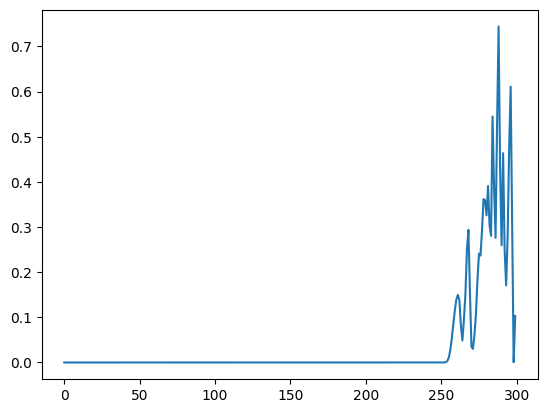

In [291]:
plt.plot(density_tensor[1409,0,:])

In [292]:
def plot_avgPool_demo(some_index = 1409, pool_width=50):
### Just checking how averaging might work on the singal
    
    # import torch.nn as nn
    my_test_layer = nn.AvgPool1d(pool_width)
    plt.figure(figsize=(8,2))
    ax = plt.subplot(121)
    ax.plot(my_test_layer(density_tensor)[some_index,0,:])
    ax.set_ylabel('AvgPool')
    ax = plt.subplot(122)
    ax.plot((density_tensor)[some_index,0,:])
    ax.set_ylabel('original Signal')

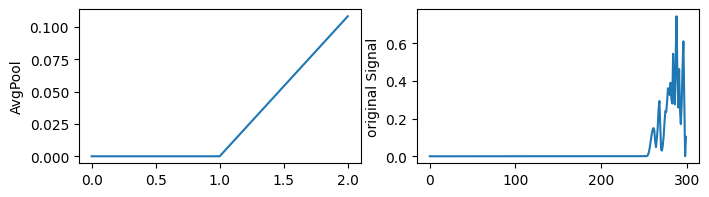

In [293]:
plot_avgPool_demo(pool_width=100)

In [294]:
train_density = density_tensor
train_source = class_tensor
train_data = TensorDataset(train_density, train_source)

In [295]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
batch_size = 100

def create_datasets(batch_size):

    # percentage of training set to use as validation
    valid_size = 0.2
    test_size =  0.2

    # convert data to torch.FloatTensor
    transform = transforms.ToTensor()

    # choose the training and test datasets


    # obtain training indices that will be used for validation
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split_val = int(np.floor(valid_size * num_train))
    split_test = int(np.floor((valid_size + test_size) * num_train))
    train_idx, valid_idx, test_idx = indices[split_test:], indices[:split_val], indices[split_val:split_test]
    
    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    
    # load training data in batches
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=train_sampler,
                                               num_workers=0,
                                               drop_last=True)
    
    # load validation data in batches
    valid_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=valid_sampler,
                                               num_workers=0,
                                               drop_last=True)
    
    # load test data in batches
    test_loader = torch.utils.data.DataLoader(train_data,
                                              batch_size=batch_size,
                                              num_workers=0,
                                              sampler=test_sampler,
                                              drop_last=True)
    
    return train_loader, test_loader, valid_loader

In [296]:
train_loader, test_loader, valid_loader = create_datasets(batch_size=batch_size)

In [320]:
### Increasing the average pool with increasing
### with Conv 3 and average pooling with 4,5,6 no improvements - goes down the hill
### with Conv 3 layers - 13%
## with conv 4 layers -  13%
### After relu1 layernormalization and so forth - to do 
## with conv 5 layers -  NAN nope

###Addign lower numeber has no good results
class SimpleCNNavg(nn.Module):
    def __init__(self, num_classes, debug=False):
        super(SimpleCNNavg, self).__init__()
        s = 2
        self.debug = debug  # Debug flag


        self.AvgPools  = [nn.AvgPool1d(w) for w in [5,10,30,50]] 

        self.conv1 = nn.Conv1d(in_channels=2, out_channels=8, kernel_size=3, stride=s, padding=1)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=3, stride=s, padding=1)
        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.Conv1d(in_channels= 16, out_channels= 32, kernel_size=3, stride=s, padding=1)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv1d(in_channels= 32, out_channels= 32, kernel_size=3, stride=s, padding=1)
        self.relu4 = nn.ReLU()

        self.conv5 = nn.Conv1d(in_channels= 32, out_channels = 64 , kernel_size=3, stride=s, padding=1)
        self.relu5 = nn.ReLU()

        self.conv6 = nn.Conv1d(in_channels= 64, out_channels = 128 , kernel_size=3, stride=s, padding=1)
        self.relu6 = nn.ReLU()
        
        self.fc1 = nn.Linear(256, 128)  # Adjusted based on the output size after convolutions
        self.relu7 = nn.ReLU()
        
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):

        avgs = []
        # Apply the average pooling layers
        for layer in self.AvgPools:
            avgs.append(layer(x)) 
            
        # Concatenate the outputs from the average pooling layers
        xcat = torch.cat(avgs, dim=2)

        h = self.conv1(xcat)
        h = self.relu1(h)
        
        h = self.conv2(h)
        h = self.relu2(h)

        h = self.conv3(h)
        h = self.relu3(h)

        h = self.conv4(h)
        h = self.relu4(h)

        h = self.conv5(h)
        h = self.relu5(h)

        
        h = self.conv6(h)
        h = self.relu6(h)
        
        h = h.view(h.size(0), -1)  # Flatten the output for the fully connected layers
        
        h = self.fc1(h)
        h = self.relu7(h)
        
        out = self.fc2(h)
        
        return out

In [321]:
# model = SimpleCNN(num_classes=9)
model = SimpleCNNavg(num_classes= 49, debug=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
# scheduler = StepLR(optimizer, step_size= .7, gamma = .9)

In [322]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)

75257


In [323]:
def train_model(model, batch_size, n_epochs):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, (data, target) in enumerate(train_loader, 1):
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        correct, total = 0, 0
        for data, target in valid_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # record validation loss
            valid_losses.append(loss.item())
            _, predicted = torch.max(output.data, 1)
            total += output.size(0)
            correct += (predicted == target).sum().item()

        accuracy = correct / total


        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f} ' +
                     f'accuracy:   {accuracy * 100:.2f}%'
                    )
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        

    return  model, avg_train_losses, avg_valid_losses
            

In [324]:
model, train_loss, valid_loss = train_model(model=model, batch_size=batch_size, n_epochs= 100)

[  1/100] train_loss: 3.75211 valid_loss: 3.50321 accuracy:   6.11%
[  2/100] train_loss: 3.36472 valid_loss: 3.31871 accuracy:   6.79%
[  3/100] train_loss: 3.26866 valid_loss: 3.31031 accuracy:   8.37%
[  4/100] train_loss: 3.24718 valid_loss: 3.19243 accuracy:   9.68%
[  5/100] train_loss: 3.14351 valid_loss: 3.14284 accuracy:   10.95%
[  6/100] train_loss: 3.20568 valid_loss: 3.22396 accuracy:   10.42%
[  7/100] train_loss: 3.16433 valid_loss: 3.11899 accuracy:   12.53%
[  8/100] train_loss: 3.11225 valid_loss: 3.19326 accuracy:   12.42%
[  9/100] train_loss: 3.11270 valid_loss: 3.11186 accuracy:   13.89%
[ 10/100] train_loss: 3.08195 valid_loss: 3.10663 accuracy:   12.16%
[ 11/100] train_loss: 3.02604 valid_loss: 3.02043 accuracy:   15.63%
[ 12/100] train_loss: 2.97658 valid_loss: 2.99592 accuracy:   15.42%
[ 13/100] train_loss: 2.95185 valid_loss: 2.98410 accuracy:   16.84%
[ 14/100] train_loss: 2.91119 valid_loss: 2.92171 accuracy:   19.11%
[ 15/100] train_loss: 2.89174 valid_lo